# ASI assessed exercise
### *Naive Bayes Classifiera* and *Bayesian Linear Regression* for MNIST and CIFAR10 datasets
7th June 2017

### MNIST dataset
------------------

<div class="label label-success">1</div> **Download the MNIST dataset and import it**

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import struct
import pickle
from time import time, strftime
from numpy.linalg import pinv,inv

In [2]:
# parameters of the MNIST dataset
num_classes = 10
img_size = 28
num_images = 60000
num_test_images = 10000

# file paths
fname_img = r'D:\ASI\MNIST\train-images.idx3-ubyte'
fname_lbl = r'D:\ASI\MNIST\train-labels.idx1-ubyte'
fname_img_test = r'D:\ASI\MNIST\t10k-images.idx3-ubyte'
fname_lbl_test = r'D:\ASI\MNIST\t10k-labels.idx1-ubyte'

# load data (input two files: data and labels)
def load_data(filename1, filename2):
    with open(filename1, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)
    with open(filename2, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)
    return img, lbl

# show given image
def show_image(image):
    image = image.reshape((img_size,img_size))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=plt.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()

In [3]:
# load the MNIST train and test datasets
img, lbl = load_data(fname_lbl, fname_img)
img_test, lbl_test = load_data(fname_lbl_test, fname_img_test)

print(lbl.shape, img.shape)
print(lbl_test.shape, img_test.shape)

(60000,) (60000, 784)
(10000,) (10000, 784)


<div class="label label-success">2</div> **Comment on the distribution of class labels and the dimentionality of the input and how these may affect the analyses**

In [2]:
# compute the prior distribution of classes
def compute_prior(lbl):
    prior = []
    for i in range(num_classes):
        prior.append(sum([1 for x in lbl if x == i])/num_images)
    return prior

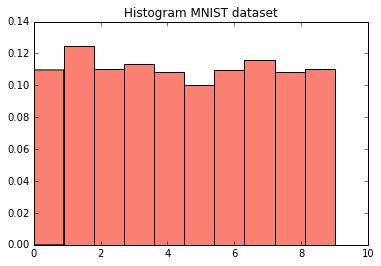

In [5]:
prior = compute_prior(lbl)

# plot histogram
plt.hist(lbl, bins=10, normed=True, color='salmon')
plt.title('Histogram MNIST dataset')
plt.show()

<div class="alert alert-warning">
The dimensionality of input is 28 x 28 = 784. Data is 784-dimensional vector of values from 0 to 255, so we will use the Gaussian likelihood.  
We can assume that the distribution of classes is uniform. Thereby, the prior almost will not have any affect to the analysis.
</div>

<div class="label label-success">3</div> **Classification**  

**a) Implement the  `Naive Bayes classifier` **

In [3]:
# compute the mean and std of each pixel for each class
def compute_mean_and_std(img):
    mean = []
    std = []
    # compute mean and std for each class
    for k in range(num_classes):
        # chose images that belongs to class k
        indices = np.argwhere(lbl == k)[:,0]
        img_ = img[indices,:]
        mean.append(np.mean(img_, axis=0))
        std.append(np.std(img_, axis=0))
    return mean, std


# compute Gaussian loglikelihood for given image and class
def compute_log_likelihood(image, k):
    # take into account only pixel that have std not equal = 0
    indices = np.argwhere(std[k] != 0)[:,0]
    std_im = std[k][indices]
    mean_im = mean[k][indices]
    image = image[indices]
    # compute loglikelihood
    llh = (- np.log(std_im) - np.log(np.sqrt(2*math.pi)) - ((image-mean_im)**2/(2*std_im**2))).sum()
    return llh


# make predictons, compute the accuracy
def predict(images, labels):
    # count correct predictions
    count = 0
    N = len(images)
    predictions = np.array([],int)
    for i in range(N):
        # compute posterior for all images for each class
        posterior = [compute_log_likelihood(images[i,:], k) * prior[k] for k in range(num_classes)]
        # make prediction (take the max posterior between 10 classes)
        pred = posterior.index(max(posterior))
        predictions = np.append(predictions, pred)
        # count correct predictions
        if pred == labels[i]:
            count += 1
    accuracy = count/N
    return predictions, accuracy


In [8]:
# test classifier and get the accuracy
mean, std = compute_mean_and_std(img)

t0 = time()
predictions, accuracy = predict(img_test,lbl_test)
t1 = time()

print('The test takes %f minutes' %((t1-t0)/60)) 
print('The accuracy = ',accuracy)

The test takes 0.148021 minutes
The accuracy =  0.5807


<div class="alert alert-info">
The accuracy = 0.5807
</div>

**с) Describe any data pre-processing that you suggest for this data and your classifier**

<div class="alert alert-warning">
The MNIST dataset provides greyscale images. We will convert greyscale images to black and white, so all pixel have 0 or 1 value and will calculate the likelihood based on the frequency of occurrence of each pixel (Bernoulli likelihood).
</div>

**d) Apply your classifier to the dataset. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit.**  

In [9]:
# convert grayscale image to black and white
def convert_images(img_grayscale):
    img_black_white = np.zeros((len(img_grayscale),img_size*img_size))
    # find non-zero values in grayscale image
    ind = np.nonzero(img_grayscale)
    # put all non-zero values to 1
    for i in range(len(ind[0])):
        a = ind[0][i]
        b = ind[1][i]
        img_black_white[a][b] = 1
    return img_black_white

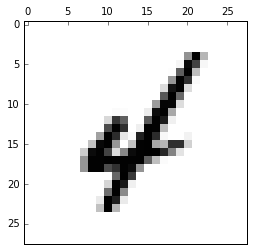

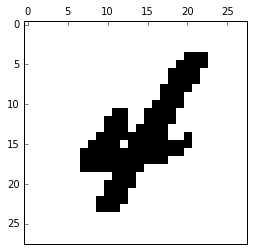

In [10]:
img_bw = convert_images(img)

# show random image before and after conversion
x = np.random.random_integers(0, high=num_images)
show_image(img[x,:])
show_image(img_bw[x,:])

In [11]:
# compute mean for black and white images
mean,_ = compute_mean_and_std(img_bw)
# convert test images 
img_bw_test = convert_images(img_test)

In [4]:
# rewrite the function that compute likelihood for given image and class
# likelihood of each pixel(0/1) is frequency of occurrence of this pixel
def compute_log_likelihood_2(image, k):
    llh = (np.log(mean[k]*image+(1-mean[k])*(np.logical_not(image).astype(int)))).sum()
    return llh

# make prediction, compute and plot accuracy
def predict_2(images, labels):
    # count correct predictions
    count = 0
    N = len(images)
    predictions = np.array([],int)
    for i in range(N):
        # compute posterior for all images for each class
        posterior = [compute_log_likelihood_2(images[i,:], k) * prior[k] for k in range(num_classes)]
        # make prediction (take the max posterior between 10 classes)
        pred = posterior.index(max(posterior))
        predictions = np.append(predictions, pred)
        # count correct predictions
        if pred == labels[i]:
            count += 1
    accuracy = count/N
    return predictions, accuracy

In [13]:
# get the results
t0 = time()
predictions, accuracy = predict_2(img_bw_test,lbl_test)
t1 = time()

print('The test takes %f minutes' %((t1-t0)/60)) 
print('The accuracy = ',accuracy)

The test takes 0.080968 minutes
The accuracy =  0.8268


<div class="alert alert-info">
The accuracy = 0.8268
</div>

**e) Display the confusion matrix on the test data.**

In [15]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(predictions, lbl_test)

# display confusion matrix: actual values are presented by rows, predicted by columns
print('Confusion matrix:\n')
print(pd.DataFrame(conf_matrix))

Confusion matrix:

     0     1    2    3    4    5    6    7    8    9
0  848     0   18   11    2   11   15    2   11    9
1    0  1038    5    5    1    1    5   16    5    7
2    2    14  846   34    4    2   14   17   10    4
3    1     2   12  701    1   31    0    1   22    4
4    1     1   18    4  798   11   12   25   12   80
5  110    44   34  173   36  810   72   14  144   32
6   11     5   29    7   17   13  839    0    5    0
7    1     0   10    9    2    0    0  811    4    9
8    6    31   58   48   15    4    1   35  734   21
9    0     0    2   18  106    9    0  107   27  843


**f) Discuss the performance, compare them against a classifier that outputs random class labels and suggest in which performance could be improved.**

<div class="alert alert-warning">
- `Naive Bayes classifier` is easy and fast to implement, it performs well and doesn't need a lot of train data.  
- We observed that its performance is better with categorical features (Bernoulli likelihood) than with continuous (Gaussian likelihood). This is due to the fact that the normal distribution is a very strong assumption.  
- For `Naive Bayes classifier` we assumed that the values of features are independent, that's not quite right, but `Naive Bayes classifier` performs well enough. We can suggest multivariate normal distribution and apply the `Bayes classifier`.  
- A classifier that outputs random class labels will provide the accuracy about 0.10, and we obtained 0.83.
</div>

<div class="label label-success">4</div> **Linear Regression**

**a) Implement `Bayesian linear regression`.**

In [16]:
# add bias to train dataset
X = np.append(img,np.ones((num_images,1)),axis=1)
t = lbl

# compute w_hat and sigma2_hat (by maximizing likelihood)
w_hat = np.dot(np.dot(pinv(np.dot(X.T,X)),X.T),t)
sigma2_hat = np.dot((t - np.dot(X,w_hat)).T,(t - np.dot(X,w_hat)))/num_images

# add bias to test dataset
X_new = np.append(img_test,np.ones((num_test_images,1)),axis=1)

In [17]:
# mean of the prior
O = np.zeros((img_size*img_size+1,1)); 
# covariance of the prior
S = 10 * np.identity(img_size*img_size+1) 

# covariance of the posterior
SIGMA = inv(1/sigma2_hat*np.dot(X.T,X) + inv(S))
# mean of the posterior
MU = 1/sigma2_hat*np.dot(np.dot(SIGMA,X.T),t)

**b) Treat class labels as continuous and apply regression to the training data.**

In [30]:
# make predictions as continuous variables and plot the prediction versus the true targets 
def predict_continuous(X_new, t_new, w):
    predictions = []
    N = len(X_new)
    
    # plot settings
    plt.figure(figsize=(20,5))
    plt.xlabel('Image number')
    plt.ylabel('True and predicted values')
    plt.grid(True)
    plt.xlim((0,N))
    
    for i in range(N):
        # predict the value
        pred = np.dot(X_new[i,:], w)
        predictions.append(pred)
        
        # plot the prediction versus the true targets 
        plt.scatter(i, pred, color='fuchsia', alpha=0.7,s=1)
        plt.scatter(i, lbl_test[i], color='limegreen', alpha=0.7,s=1)

    plt.show()
    return predictions


**c) Produce a scatter plot showing the prediction versus the true targets for the test set and compute the mean squared error on the test set**

In [ ]:
# make the predictions with MU as the value of model parameters
predictions = predict_continuous(X_new,lbl_test,MU)

error = predictions - lbl_test
print('mean of error:',np.mean(error),'\nstd of error:',np.std(error))

In [28]:
# compute MSE
def compute_mse(predictions, targets):
    MSE = ((predictions - targets)**2).sum()/num_test_images
    return MSE

MSE = compute_mse(predictions, lbl_test)
print('MSE on the test set:',round(MSE,4))

MSE on the test set: 3.151


**d) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy**

<div class="alert alert-warning">
To discretize predictions we can round obtained values up to integers. It will be more correct mathematically, but if we take only integer part of predictions, we will obtain accuracy slightly bigger (the difference is 4%).
</div>

In [31]:
def predict_discrete(X_new, t_new, w):
    N = len(X_new)
    count = 0
    #predictions = []
    predictions = np.array([],int)
    for i in range(N):
        # discretize predictions by mathematical rounding of prediction
        pred = int(round(np.dot(X_new[i,:], w),0))
        # discretize predictions by taking integer part of prediction
        #pred = int(np.dot(X_new[i,:], w))
        #predictions.append(pred)
        predictions = np.append(predictions, pred)
        # count correct predictions
        if pred == t_new[i]:
            count += 1
    accuracy = count/N
    return predictions, accuracy


In [19]:
# get the results with MU as the value of model parameters
predictions, accuracy = predict_discrete(X_new,lbl_test, MU)
print('The accuracy =',accuracy)

The accuracy = 0.2208


<div class="alert alert-info">
The accuracy = 0.2208 (0.2599)  
</div>

In [20]:
conf_matrix = confusion_matrix(predictions, lbl_test)

# display confusion matrix: actual values are presented by rows, predicted by columns
print('Confusion matrix:\n', conf_matrix)

Confusion matrix:
 [[  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  50   0   4   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 173   1  31   7   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0 328 229 123  43   0   3   4   1   1   1   0   0   0   0]
 [  0   0   0 257 570 244 196   5  21  24   6  10   4   0   0   0   0]
 [  0   0   0 103 222 304 325  36 118  73  26  27   9   0   0   0   0]
 [  0   0   0  36  88 217 273 197 253 158  74 100  25   0   0   0   0]
 [  0   0   0  22  18  84 100 338 288 265 141 189  58   0   0   0   0]
 [  0   0   0   8   6  18  42 249 143 270 241 277 142   0   0   0   0]
 [  0   0   0   2   1   1  12 115  36 117 283 229 312   0   0   0   0]
 [  0   0   0   0   0   3   9  39  19  43 159 103 319   0   0   0   0]
 [  0   0   0   0   0   0   3   3   5   2  70  29  96   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0  19   8  36   0 

In [57]:
# sample from the posterior distribution of the parameters of the model and compute expectation of w
num_samples = 100000
samples = np.random.multivariate_normal(mean=MU,cov=SIGMA,size=num_samples)
expected_w = np.mean(samples, axis=0)

# make predictions and compute the accuracy with expected value of w
predictions, accuracy = predict_discrete(X_new,lbl_test,expected_w)
print('The accuracy =',accuracy)

The accuracy = 0.2205


<div class="alert alert-info">
The accuracy = 0.2205
</div>

<div class="alert alert-warning">
The average of parameters of model tends to mean of this model (MU), if we produce more samples the accuracy will be closer to the accuracy obtained with MU (0.2208).
</div>

**e) Discuss regression performance with respect to classification performance**

<div class="alert alert-warning">
The performance of Linear regression is low, because regression is not the best fit for classification problems. For regression the output variable takes continuous values, for classification the output variable takes class labels. Output variable can be a discrete value like in our case, but these class labels don't have any order. We can change the order of our labels and we will obtain a different result.
</div>

**f) Describe one limitation of using regression for this particular task**

<div class="alert alert-warning">
Regression and classification are both related to prediction, where regression predicts a value from a continuous set, whereas classification predicts the 'belonging' to the class. We can use regresion for classification task where the output variable is ordinal. For example if we want to predict the price where the price is categorical like: 'very expensive', 'expensive', 'affordable', 'cheap', and 'very cheap'.  
For this particular task we shold use `Bayesian Logistic regression`.
</div>

### CIFAR10
-----------

<div class="label label-success">1</div> **Download the CIFAR10 dataset and import it**

In [18]:
path = r'D:\ASI\CIFAR10\cifar-10-batches-py'
filename = [path + '\data_batch_' + str(x) for x in list(range(1, 6))]
filename_test = r'D:\ASI\CIFAR10\cifar-10-batches-py\test_batch'

num_classes = 10
num_channels = 3
img_size = 32
num_images_per_file = 10000
num_images = 5 * num_images_per_file
num_images_test = 10000

In [5]:
# unpickle data from file
def unpickle(file):
    with open(file, mode='rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

# convert and reshape the raw data 
def convert_images(raw):
    # convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    # reshape the array to 4-dimensions
    images = raw_float.reshape([-1, num_channels, img_size, img_size])
    # reorder the indices of the array
    images = images.transpose([0, 2, 3, 1])
    return images

# load data from file
def load_data(filename):
    data = unpickle(filename)
    raw_img = data[b'data']
    lbl = np.array(data[b'labels'])
    img = convert_images(raw_img)
    return img, lbl

# load all train data (from 5 files)
def load_training_data(filename):
    img,lbl = load_data(filename[0])
    for i in range(4):
        img_,lbl_ = load_data(filename[i+1])
        tmp_img = np.append(img, img_, axis=0)
        tmp_lbl = np.append(lbl, lbl_, axis=0)
        img = tmp_img
        lbl = tmp_lbl
    return img, lbl

# show given image
def show(image):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=plt.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()
    

In [6]:
# loading the training data
img, lbl = load_training_data(filename)
# loading the test data
img_test, lbl_test = load_data(filename_test)

print(img.shape, lbl.shape)
print(img_test.shape, lbl_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


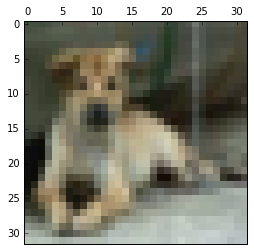

In [12]:
#show random image     
x = np.random.random_integers(0, high=num_images)
show(img[x,:,:,:])

<div class="label label-success">2</div> **Comment on the distribution of class labels and the dimentionality of the input and how these may affect the analyses**

prior: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


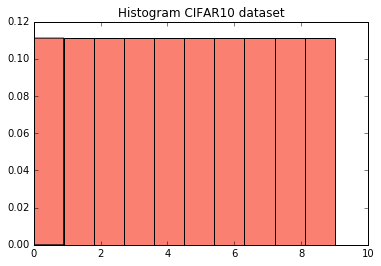

In [7]:
# compute the prior
prior = compute_prior(lbl)
print('prior:',prior)

# plot histogram
plt.hist(lbl, bins=10, normed=True, color='salmon')
plt.title('Histogram CIFAR10 dataset')
plt.show()

<div class="alert alert-warning">
According to the histogram above the distribution of class labels is exactly uniform. The prior distribution will not have any affect to the analysis.   
The dimentionality of input is 32 x 32 x 3 = 1024 x 3. Data is 1024x3 dimensional matrix of values from 0 to 1. The dimentionality is high, we can suggest a way to reduce it. 
</div>

<div class="label label-success">3</div> **Classification**  

**a) Implement the  `Naive Bayes classifier` **

In [8]:
# compute the mean and std of each pixel for each channel for each class for given image
def compute_mean_and_std_2(images):
    # reshape images
    img_ = images.reshape((num_images,img_size*img_size,num_channels))
    mean = []
    std = []
    for k in range(num_classes):
        # chose images that belongs to class k
        indices = np.argwhere(lbl == k)[:,0]
        img_class = img_[indices,:]
        mean_class = []
        std_class = []
        # compute mean and std for each channel for given class
        for i in range(num_channels):
            mean_class.append(np.mean(img_class[:,:,i], axis=0))
            std_class.append(np.std(img_class[:,:,i], axis=0))
        mean.append(mean_class)
        std.append(std_class)
    return mean, std


# compute Gaussian loglikelihood for given image and class for each channel
def compute_log_likelihood_3(image, k):
    llh = 0
    for x in range(num_channels):  
        llh_channel = 0
        indices = np.argwhere(std[k][x][:] != 0)[:,0]
        std_im = std[k][x][indices]
        mean_im = mean[k][x][indices]
        image_im = image[indices,x]
        llh_channel = (-np.log(std_im)-np.log(np.sqrt(2*math.pi))-((image_im-mean_im)**2/(2*std_im**2))).sum()
        llh = llh + llh_channel
    return llh


# make predictions
def predict_3(images, labels):
    count = 0
    N = len(images)
    images_ = images.reshape((N,img_size*img_size,num_channels))
    predictions = np.array([], int)
    # compute posterior for each image
    for i in range(N):
        posterior = [compute_log_likelihood_3(images_[i,:,:], k) * prior[k] for k in range(num_classes)]
        pred = posterior.index(max(posterior))
        predictions = np.append(predictions, pred)
        if pred == labels[i]:
            count += 1
    accuracy = count/N
    return predictions, accuracy  

In [9]:
mean, std = compute_mean_and_std_2(img)

t0 = time()
predictions, accuracy = predict_3(img_test,lbl_test)
t1 = time()

print('The test takes %f minutes' %((t1-t0)/60))
print('The accuracy = ',accuracy)

The test takes 0.512267 minutes
The accuracy =  0.2976


<div class="alert alert-info">
The accuracy = 0.2976
</div>

**с) Describe any data pre-processing that you suggest for this data and your classifier**

<div class="alert alert-warning">
Because the dimensionality is very high we should find a way to reduce it. The simplest one can be averaging the values of these three RGB channels or we can apply PCA.
</div>

**d) Apply your classifier to the dataset. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit.**  

In [10]:
img = img.reshape(50000, 32*32*3)
img_test = img_test.reshape(10000, 32*32*3)

In [11]:
from sklearn.decomposition import PCA

print('The start at:', strftime("%H:%M:%S"))
t0 = time()

pca = PCA(n_components=80)
pca.fit(img)

t1 = time()

img_opt = pca.transform(img)
img_test_opt = pca.transform(img_test)

t2 = time()
print('Building the model takes %f minutes' %((t1-t0)/60)) 
print('Applying the dimensionality reduction takes %f minutes' %((t2-t1)/60)) 

The start at: 09:40:13
Building the model takes 4.677074 minutes
Applying the dimensionality reduction takes 1.871455 minutes


In [12]:
# compute mean and std for obtained images
mean, std = compute_mean_and_std(img_opt)

# make predictions and compute the accuracy
t0 = time()
predictions, accuracy = predict(img_test_opt,lbl_test)
t1 = time()

print('The test takes %f minutes' %((t1-t0)/60)) 
print('The accuracy = ',accuracy)


The test takes 0.101828 minutes
The accuracy =  0.3442


<div class="alert alert-info">
The accuracy = 0.3442
</div>

**e) Display the confusion matrix on the test data.**

In [14]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(predictions, lbl_test)

# display confusion matrix: actual values are presented by rows, predicted by columns
print('Confusion matrix:\n')
print(pd.DataFrame(conf_matrix))


Confusion matrix:

     0    1    2    3    4    5    6    7    8    9
0  240   49   44   36   29   23   13   41   75   61
1   79  428   40   59   21   52   38   55  104  160
2   36   20  100   67   69   81   39   41   20   11
3   43   43   75  217   42  130   56   63   30   51
4  243   51  423  183  597  193  332  181  175   49
5   26   28   75  130   39  260   55   74   30   18
6   31   34   89  104   84   72  368   48   33   36
7   43   37   53   63   68   74   29  339   22   36
8  167  123   38   25   28   26   14   31  431  116
9   92  187   63  116   23   89   56  127   80  462


**f) Discuss the performance, compare them against a classifier that outputs random class labels and suggest in which performance could be improved.**

<div class="alert alert-warning">
The classifier that outputs random class labels will provide the accuracy about 0.10, and we obtained about 0.34. It's better but still very low. To get better result we should take into account the сorrelation between pixels by assuming multivariate normal distribution and applying the `Bayes classifier`.   
Moreover we can use `Convolutional Neural Networks` to perform this classification task.
</div>

<div class="label label-success">4</div> **Linear Regression**

**a) Implement `Bayesian linear regression`**

In [39]:
# add bias to train dataset
X = np.append(img,np.ones((num_images,1)),axis=1)
t = lbl

# compute w_hat and sigma2_hat (by maximizing likelihood)
w_hat = np.dot(np.dot(pinv(np.dot(X.T,X)),X.T),t)
sigma2_hat = np.dot((t - np.dot(X,w_hat)).T,(t - np.dot(X,w_hat)))/num_images

# add bias to test dataset
X_new = np.append(img_test,np.ones((num_images_test,1)),axis=1)

In [40]:
# mean of the prior
O = np.zeros((32*32*3+1,1)); 
# covariance of the prior
S = 10 * np.identity(32*32*3+1) 

# compute the covariance of the posterior
SIGMA = inv(1/sigma2_hat*np.dot(X.T,X) + inv(S))
# compute the mean of the posterior
MU = 1/sigma2_hat*np.dot(np.dot(SIGMA,X.T),t)

**b) Treat class labels as continuous and apply regression to the training data**

**c) Produce a scatter plot showing the prediction versus the true targets for the test set and compute the mean squared error on the test set**

In [ ]:
# get the results with MU as parameters of the model and predictions as continuous values 
predictions = predict_continuous(X_new,lbl_test,MU)

# compute error for all points
error = predictions - lbl_test
print('mean of error:',np.mean(error),'\nstd of error:',np.std(error))

In [42]:
# the mean squared error on the test set
MSE = compute_mse(predictions, lbl_test)
print('MSE on the test set:',round(MSE,4))

MSE on the test set: 7.8779


**d) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy**

In [43]:
# get the results with the best value for the modl = MU and predictions as discrete values
predictions, accuracy = predict_discrete(X_new, lbl_test, MU)
print('\nThe accuracy =',accuracy)


The accuracy = 0.1131


<div class="alert alert-info">
The accuracy = 0.1131
</div>

<div class="alert alert-warning">
The obtained accuracy is equivalent to the accuracy that we will get with classifier that outputs random class variables.
</div>

In [44]:
# display confusion matrix: actual values are presented by rows, predicted by columns
conf_matrix = confusion_matrix(predictions, lbl_test)

print('Confusion matrix:\n')
print(pd.DataFrame(conf_matrix))

Confusion matrix:

    0    1    2    3    4    5    6    7    8    9    10  11
0    0    0    0    0    1    0    0    0    0    0    1   0
1    0    0    0    0    1    0    1    0    0    0    0   0
2    0    5   10    2    5    2    2    0    2    1    2   0
3    0   31   40   24   37   18   33   11   10    9    7   0
4    0  236  155  157  162  143  167  107   93   60   71   0
5    0  411  353  430  394  411  383  328  299  321  195   0
6    0  226  275  304  298  331  311  392  322  408  348   0
7    0   75  119   66   89   78   89  134  187  158  260   0
8    0   12   35   12   10   16   13   22   67   36   88   0
9    0    2   10    4    3    1    1    6   15    7   20   0
10   0    2    3    1    0    0    0    0    5    0    5   0
11   0    0    0    0    0    0    0    0    0    0    3   0


**e) Discuss regression performance with respect to classification performance**


<div class="alert alert-warning">
Given above for the MNIST dataset.
</div>

**f) Describe one limitation of using regression for this particular task**

<div class="alert alert-warning">
Given above for the MNIST dataset.
</div>